## This notebook deals with the data science challenge of haensel-ams 
The main goal is to predict the target - price - values accurately after cleaning the data and modeling with the 8 features provided in the csv. Conclusively, the task is a supervised learning problem - **a regression**. 

- first the data is visualized to gain an overview
- it is then cleaned and prepared for modeling
- lastly three different <a href="#Modeling">models</a> are evaluated

### Fast-forward:
<a href="#Results">Results</a><br>
<a href="#Outlook">Outlook</a>


In [1]:
#first all the necessary libraries are imported

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBRegressor

%matplotlib inline

/Users/Maik/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# the data is loaded into a pandas dataframe and subsequently the shape 
# and the first 5 rows are shown to have an overview
df = pd.read_csv('../haensel-ams/data/sample.csv')
df.shape

(10000, 8)

In [3]:
# 10000 samples and each has 7 features + the target column
df.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [4]:
# next the data types are inspected to get an overview of what might be a numerical and categorical feature
df.dtypes

loc1      object
loc2      object
para1      int64
dow       object
para2      int64
para3    float64
para4    float64
price    float64
dtype: object

**At first glance one column contains names of weekdays ('dow') which can be left as is but should be transformed using one hot encoding.
**

In [5]:
# a closer look at the loc1/loc2 data reveals the following columns: loc1- T,S, loc2- 0N, 0T, 0L, 0B, TS, S6, 0C
# since the loc1 and loc2 features contain letters and appear to be categories
# they should be transformed using one hot encoding lateron

# df['loc1'].value_counts()
df['loc2'].value_counts()

21    499
06    454
74    329
12    273
14    246
01    241
22    226
50    217
23    215
89    194
09    192
04    180
20    168
15    168
67    167
16    166
31    160
19    149
28    149
39    146
59    142
47    139
08    137
99    133
85    130
13    128
90    127
49    127
76    123
63    119
     ... 
36     43
44     43
46     42
81     40
10     39
05     38
92     37
96     35
94     35
65     34
60     31
17     28
98     25
84     24
18     24
69     15
80     11
61     10
82      9
62      5
11      2
0B      1
0T      1
0C      1
43      1
00      1
0L      1
TS      1
0N      1
S6      1
Name: loc2, Length: 107, dtype: int64

In [6]:
# additionally it appears that loc1 is always equal to the first item in loc2 
# -> equality of the first digit in the loc2 feature and the loc1 feature is tested and found to be true
print((df['loc1'] == df['loc2'].str[0]).all())

True


In [7]:
# since they are always equal, we can replace the loc2 feature with its second digit/letter in order to reduce duplicity of information
df['loc2'] = df.loc2.str[1]

In [8]:
#for item in ['loc1', 'loc2']:
#    df[item] = pd.to_numeric(df[item], errors='coerce')
#    df[item] = df.fillna(df[item].mean)
#df = df.dropna()

rbst_sclr = RobustScaler()
std_sclr = StandardScaler()
mima_sclr = MinMaxScaler()
para2_t = df['para2'].values.reshape(-1,1)
df['para2_t'] = mima_sclr.fit_transform(para2_t)

para3_t = df['para3'].values.reshape(-1,1)
df['para3_t'] = mima_sclr.fit_transform(para3_t)

para4_t = df['para4'].values.reshape(-1,1)
df['para4_t'] = mima_sclr.fit_transform(para4_t)
df.head()

In [9]:
# the categorical features are now transformed using one hot encoding.
df = pd.get_dummies(df, columns=['loc1', 'loc2', 'dow'])

In [10]:
# para1 is a feature containing numbers, however the first five rows contained only 0 and 1 so it is explored whether 
# this is a binary feature -> apparently most of the rows contain a values between 0 and 5, while some are in the range
# of 7-13 and the values 24 and 337 only appear once 
# -> this is not a binary column and contains only discrete numbers 
# -> could be left as is for further analysis
df['para1'].value_counts()

1      7052
3      1613
0       836
2       268
4       164
5        51
6         6
7         3
13        2
9         2
337       1
24        1
8         1
Name: para1, dtype: int64

### Visual exploration

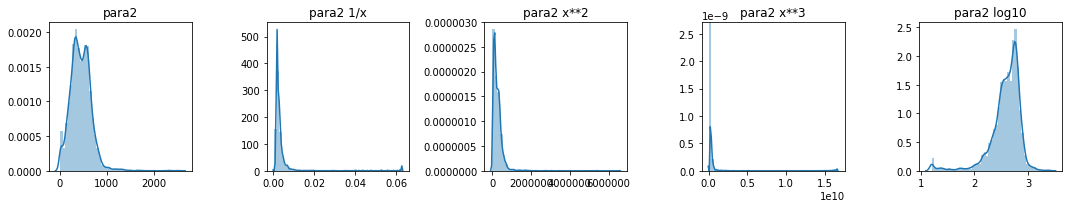

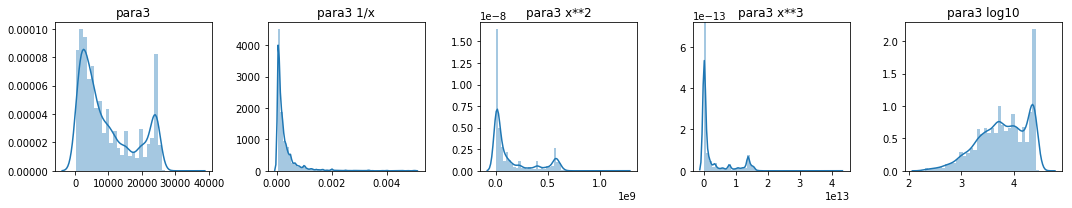

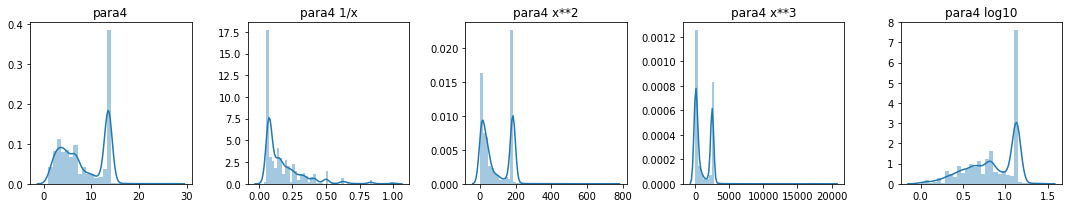

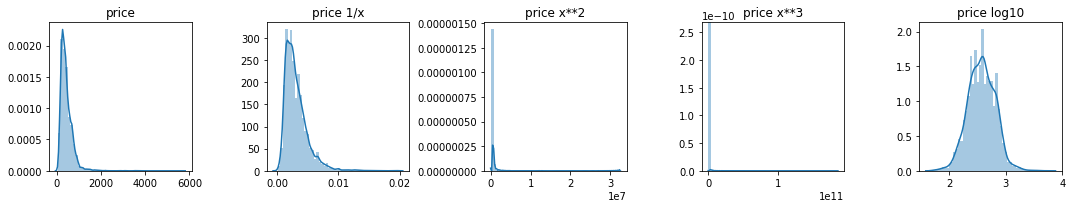

In [11]:
# for the other features visual exploration starts with feature transformation using different lambda functions 
# this was chosen since their datatypes indicated that they only contain numbers
# the approach was additionally chosen as an alternative to automated polynomial feature transformation due to its broader spectrum

df_t = pd.DataFrame()
transformations = {'1/x': lambda x: 1/x, 
                  'x**2': lambda x: x**2,
                  'x**3': lambda x: x**3,
                  'log10': lambda x: np.log10(x)
                  }

for item in ['para2', 'para3', 'para4', 'price']:
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
    axs[0].set_title(item)
    norm = sns.distplot(df[item], ax=axs[0])
    norm.set(xlabel='', ylabel='')
    
    for i, (keys, values) in enumerate(transformations.items()):
        df_t['{}_{}'.format(item, keys)] = df[item].apply(values)
        axs[i+1].set_title(item + ' ' + keys)
        p =sns.distplot(df_t['{}_{}'.format(item, keys)], ax=axs[i+1])
        p.set(xlabel='', ylabel='')
    # fig.savefig('./' + item + '.png')
    plt.tight_layout()
    

In [12]:
# looking at the numerical feature transformations the decadic logarithm of the price column appears to be a gaussian distribution
# this will be used to accurately predict correct the magnitude of the price rather than the actual price
df['price_log'] = np.log10(df['price'])

**The data is now transformed and ready for modeling.**<br>
The transformed dataframe is saved to disk in case of collaboration or other use cases. 

In [13]:
df.to_csv('./df_cleaned.csv')

### Modeling

In [14]:
# for modeling the target (y) and estimators (x) need to be defined
y = df['price_log']
x = df.drop(['price', 'price_log'], axis='columns')
x.head()

,para1,para2,para3,para4,loc1_0,loc1_1,loc1_2,loc1_3,loc1_4,loc1_5,...,loc2_N,loc2_S,loc2_T,dow_Fri,dow_Mon,dow_Sat,dow_Sun,dow_Thu,dow_Tue,dow_Wed
0,1,662,3000.0,3.8,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,340,2760.0,9.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,16,2700.0,3.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,17,12320.0,6.4,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,610,2117.0,10.8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [15]:
# the data is seperated into training and testing data in order to validate the model correctly
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=291)

In [16]:
def print_scores(regressor, X_train, y_train, X_test, y_test):
    """
    This function uses supplied regressor algorithms to train a model and predict
    the target value.
    Ultimately the accuracy and other scoring parameters (R2, MSE, RMSE, LRMSE) are printed
    """
    regressor.fit(X_train, y_train)
    y_prediction = regressor.predict(X_test)
    accuracy = accuracy_score(y_true = y_test.astype(int), y_pred = y_prediction.astype(int))
    print('Variance-score (R^2): {0:.4f}'.format(regressor.score(X_test, y_test)))
    print('Mean squared error: {0:.4f}'.format(np.mean((regressor.predict(X_test) - y_test) ** 2)))
    print('Root mean squared error: {0:.4f}'.format(np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))))
    print('log root mean squared error: {0:.4f}'.format(np.sqrt(np.square(np.log(y_prediction + 1) - np.log(y_test + 1)).mean())))
    print('Accuracy: {0:.2f}%'.format(accuracy*100))
    return accuracy

In [17]:
# first a simple linear regression model from scikitlearn is used 
print_scores(LinearRegression(), X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.6280
Mean squared error: 0.0218
Root mean squared error: 0.1475
log root mean squared error: 0.0423
Accuracy: 96.44%


0.96440000000000003

This can be seen as the **score baseline for further modeling.**<br><br><br>
For further analysis regularization of the regression model, namely **Ridge regression**, shall be applied. Ridge was chosen due to its ability to reduce the influence of "non-important" features but not delete it. 

In [21]:
print_scores(Ridge(alpha=0.1, normalize=True), X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.6228
Mean squared error: 0.0221
Root mean squared error: 0.1485
log root mean squared error: 0.0426
Accuracy: 96.52%


0.96519999999999995

<br><br><br>Recently a lot of attention has been generated by **cross gradient boosting algorithms (XGB)**. These algorithms can be used to accurately predict regression problems as well.

In [22]:
regressor = XGBRegressor()
print_scores(regressor, X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.6746
Mean squared error: 0.0190
Root mean squared error: 0.1380
log root mean squared error: 0.0398
Accuracy: 97.00%


0.96999999999999997

<br>
## Results
Out of the three tested algorithms **gradient boosting** performed the best **(97% accuracy)**.<br>
This can be measured by increased variance score (0.6280 -> 0.6746), <br>
decreasing mean squared errors and a ~0.6% increased accuracy in predicting the target in the test data set. <br>
The model seems to generalize well but could be further evaluated using kmeans.<br><br>

## Outlook
Most algorithms were used without hyperparameter manipulation and hence can be tuned further for higher accuracy. Additionally, based on the following feature importance plot it seems that the 'para2' feature has the largest influence on the outcome of price. Further analysis could focus on the interaction of these two. 

Text(0,0.5,'Feature Importance Score')

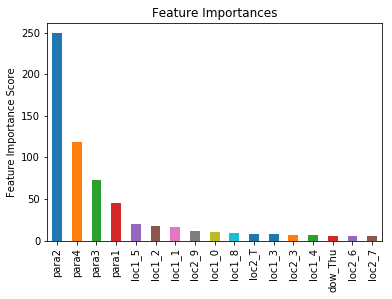

In [23]:

predictors = [x for x in df.columns if x not in y]
s = pd.Series(regressor.booster().get_score(importance_type='weight'), predictors).sort_values(ascending=False)
s = s[s > 5]
s.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

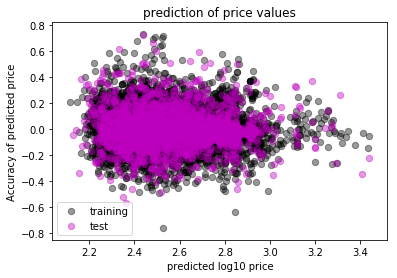

In [24]:
plt.scatter(regressor.predict(X_train), regressor.predict(X_train) - y_train, c='black', s=40, label='training', alpha=0.4)
plt.scatter(regressor.predict(X_test), regressor.predict(X_test) - y_test, c='m', s=40, label='test', alpha=0.4)
plt.legend(loc='lower left')
plt.title('prediction of price values')
plt.xlabel('predicted log10 price')
plt.ylabel('Accuracy of predicted price')
plt.show()